## Generating intensity table for DHS sites

- Give an overview of data samples, with metadata
- Run coverage_table in Gimme Motif

#### Loading the important dependencies

In [1]:
%load_ext nb_black
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import os
import pandas as pd
import subprocess as sp
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import warnings
import qnorm

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    AffinityPropagation,
)  # For clustering
from sklearn.decomposition import PCA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Setting file paths

In [3]:
## General locations
exp_path = "/scratch/snabel/GEODatasets_CMenhancers"
bam_path = "/scratch/snabel/GEODatasets_CMenhancers/results/testset/"

samplesheet = "/scratch/snabel/GEODatasets_CMenhancers/samplesheet_all.tsv"
metadata = "/scratch/snabel/GEODatasets_CMenhancers/metadata.tsv"

## Files for coverage_table
dhs_file = "/scratch/snabel/GEODatasets_CMenhancers/Meuleman_DHSs_2019/ENCFF503GCK_summit_10k.bed"
dhs_set = "10k"
coveragetable = "/scratch/snabel/GEODatasets_CMenhancers/10k_2000bp_window_coverage_table_logt.txt"
rerun_coverage_table = False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Setting parameters

In [4]:
window = "2000"
marks = ["H3K27ac", "H3K4me3"]
colors = {"H3K27ac": "#1F78B4", "H3K4me3": "#33A02C"}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Selecting the metadata for the samples of interest
Multiple samples did not run for the SRA dump, did not have an SRA entry or are an input sample (only needed earlier on in the workflow), therefore from the large metadata, only the samples used for analysis will be selected.

In [5]:
samplesh_df = pd.read_table(samplesheet, na_values=["NaN"], keep_default_na=False)
# only keeping the files without an entry in the problems column
samplesh_df = samplesh_df[samplesh_df["problems"] == ""]
sample_ids = samplesh_df[["sample", "descriptive_name"]]

# large metatable with all samples + input
metadf = pd.read_table(metadata, na_values=["NaN"], keep_default_na=False)

# keep only the samples that were aligned
metadf_merge = pd.merge(
    left=sample_ids, right=metadf, on="sample", how="left", validate="one_to_one"
)
metadf_merge[:5]

,sample,descriptive_name,mark,target,source_tissue,source_tissue.1,cell_type,sex,age,title,comment,search_method,input,input01,accessibility_SRA,output_downloadfastq
0,GSM4146415,adult_H3K27ac_right.ventricle_auricle_tr1,H3K27ac_RA_auricle,H3K27ac,atrium,atrium_auricle,mix,,adult,Histone_ChIP-seq_from_right_atrium_auricular_r...,Histone_ChIP-seq_from_right_atrium_auricular_r...,series_in_GEO,,,np,
1,GSM4146416,adult_H3K27ac_right.ventricle_auricle_tr2,H3K27ac_RA_auricle,H3K27ac,atrium,atrium_auricle,mix,,adult,Histone_ChIP-seq_from_right_atrium_auricular_r...,Histone_ChIP-seq_from_right_atrium_auricular_r...,series_in_GEO,,,np,
2,GSM4051113,adult_H3K27ac_left.ventricle_tr1,H3K27ac_LV,H3K27ac,left_ventricle,left_ventricle,mix,,adult,Histone_ChIP-seq_from_heart_left_ventricle_-EN...,Histone_ChIP-seq_from_heart_left_ventricle_-EN...,series_in_GEO,,,np,
3,GSM4051114,adult_H3K27ac_left.ventricle_tr2,H3K27ac_LV,H3K27ac,left_ventricle,left_ventricle,mix,,adult,Histone_ChIP-seq_from_heart_left_ventricle_-EN...,Histone_ChIP-seq_from_heart_left_ventricle_-EN...,series_in_GEO,,,np,
4,GSM3832542,adult_H3K4me3_endothelial_HAoEC_13,EC_013_HAoEC_ChIP-seq_H3K4me3,H3K4me3,vascular_system,vascular_system,endothelial_cells,,adult,Nine_endothelial_cell_types,PMID_31856914,series_in_GEO,,,not_found_SampleSearch_SRA_available,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### How many samples per source tissue are present for the marks of interest?

In [6]:
metadf_merge.source_tissue.value_counts()
metadf_merge.target.value_counts()
crosstab_df = pd.crosstab(
    index=metadf_merge["source_tissue"], columns=metadf_merge["target"], margins=True
)
# Show the tissues of which the marks of interest are present
crosstab_df[marks]

target,H3K27ac,H3K4me3
source_tissue,,
aorta,5,4
atrium,4,1
coronary_artery,4,0
heart,10,7
in_vitro,22,2
left_ventricle,25,2
right_ventricle,2,2
vascular_system,35,33
All,107,51


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Running coverage_table
Coverage_table needs as input the bam files and a bed file, the bed file defines the regions in which the reads will be counted per sample. In this case the DNase I hypersensibility sites (Meuleman et al. 2020) will be used as open regions to query. Selecting the bam files to run.

In [14]:
bamfiles_path = [
    os.path.abspath(os.path.join(bam_path, p))
    for p in os.listdir(bam_path)
    if p.endswith((".bam"))
]

# generating the same list without file path
bamfiles = [file for file in os.listdir(bam_path) if file.endswith(".bam")]
bamfiles = [re.sub(".samtools-coordinate.bam", "", x) for x in bamfiles]
bamfiles = [re.sub("^GRCh38-", "", x) for x in bamfiles]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Select from the metadata the samples used for running coverage_table.

In [10]:
samples_meta = metadf_merge[np.isin(metadf_merge["descriptive_name"], bamfiles)]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Running the coverage_table command in bash
Coverage_table will also perform a log2 transformation.

In [11]:
if rerun_coverage_table == True:
    print("running coverage table ")
    input_file = " ".join(bamfiles_path)
    filename = dhs_set + "_" + window + "bp_window_coverage_table_logt"
    output_file = filename + ".txt"
    log_file = filename + ".log"
    print(
        "using "
        + str(len(bamfiles_path))
        + " supplied files (check "
        + output_file
        + ")"
    )
    sp.check_call(
        f"coverage_table "
        f"-p {dhs_file} "
        f"-d {input_file} "
        f"> {exp_path}/{output_file} "
        f"-w {window} -l "
        f"2> {exp_path}/{log_file}",
        shell=True,
    )
else:
    output_file = coveragetable

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Load the coverage table per mark into a dataframe

Generate clean sample names for the coverage_table columns using the bamfilenames, stripped of assembly name and filename extension. 

In [15]:
# The first column of the coverage_table output, is always the location/region
cov_column_names = bamfiles
cov_column_names.insert(0, "region")

## Create a df with the loaded output file, containing 9 rows of information regarding the run
coverage_table_df = pd.read_table(
    f"{output_file}", skiprows=9, index_col=0, names=cov_column_names
)
coverage_table_df[:5]

,child_H3K27ac_right.ventricle_STL001RV,fetal_H3K27ac_fibroblasts_1,child_H3K4me3_right.ventricle_STL001RV,PCW10_H3K27ac_left.ventricle_12522,adult_H3K27ac_left.ventricle_LV1277,adult_H3K27ac_endothelial_HENDC_42,adult_H3K27ac_endothelial_HAoEC_13,adult_H3K4me3_endothelial_HENDC_59,fetal_H3K4me3_fibroblasts_2,fetal_H3K27ac_fibroblasts_2,adult_H3K4me3_left.ventricle_STL003LV,PCW10_H3K27ac_left.ventricle_12434,adult_H3K27ac_left.ventricle_LV1356,adult_H3K4me3_endothelial_HAoEC_60,fetal_H3K4me3_fibroblasts_1
region,,,,,,,,,,,,,,,
20:35005700-35007700,3.58352,1.60944,2.48491,3.68888,3.98898,3.29584,3.73767,3.21888,1.09861,1.79176,2.39790,3.49651,3.82864,3.04452,0.69315
3:30354210-30356210,3.73767,3.17805,2.56495,4.67283,5.19296,3.33220,3.52636,3.33220,3.55535,3.80666,2.77259,5.29832,4.95583,2.77259,2.83321
10:6737650-6739650,2.07944,2.70805,2.48491,2.56495,3.13549,2.56495,3.17805,2.94444,4.29046,3.43399,4.06044,1.94591,4.38203,2.70805,4.00733
7:11742190-11744190,0.00000,1.60944,2.39790,2.39790,2.77259,3.13549,2.56495,3.09104,2.30259,1.79176,1.79176,2.70805,2.19722,2.94444,1.79176
11:104798430-104800430,0.00000,1.38629,2.70805,1.94591,3.13549,2.39790,2.89037,2.83321,2.30259,1.94591,1.38629,1.94591,2.63906,2.63906,2.30259


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Make a dictionary with a df per mark.
dict_of_dfs = {}

for mark in marks:
    mark_samples = samples_meta.loc[samples_meta["target"] == mark].descriptive_name
    dict_of_dfs[mark] = coverage_table_df[mark_samples]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Generate a distribution plot per sample. 
Before and after quantile normalization.

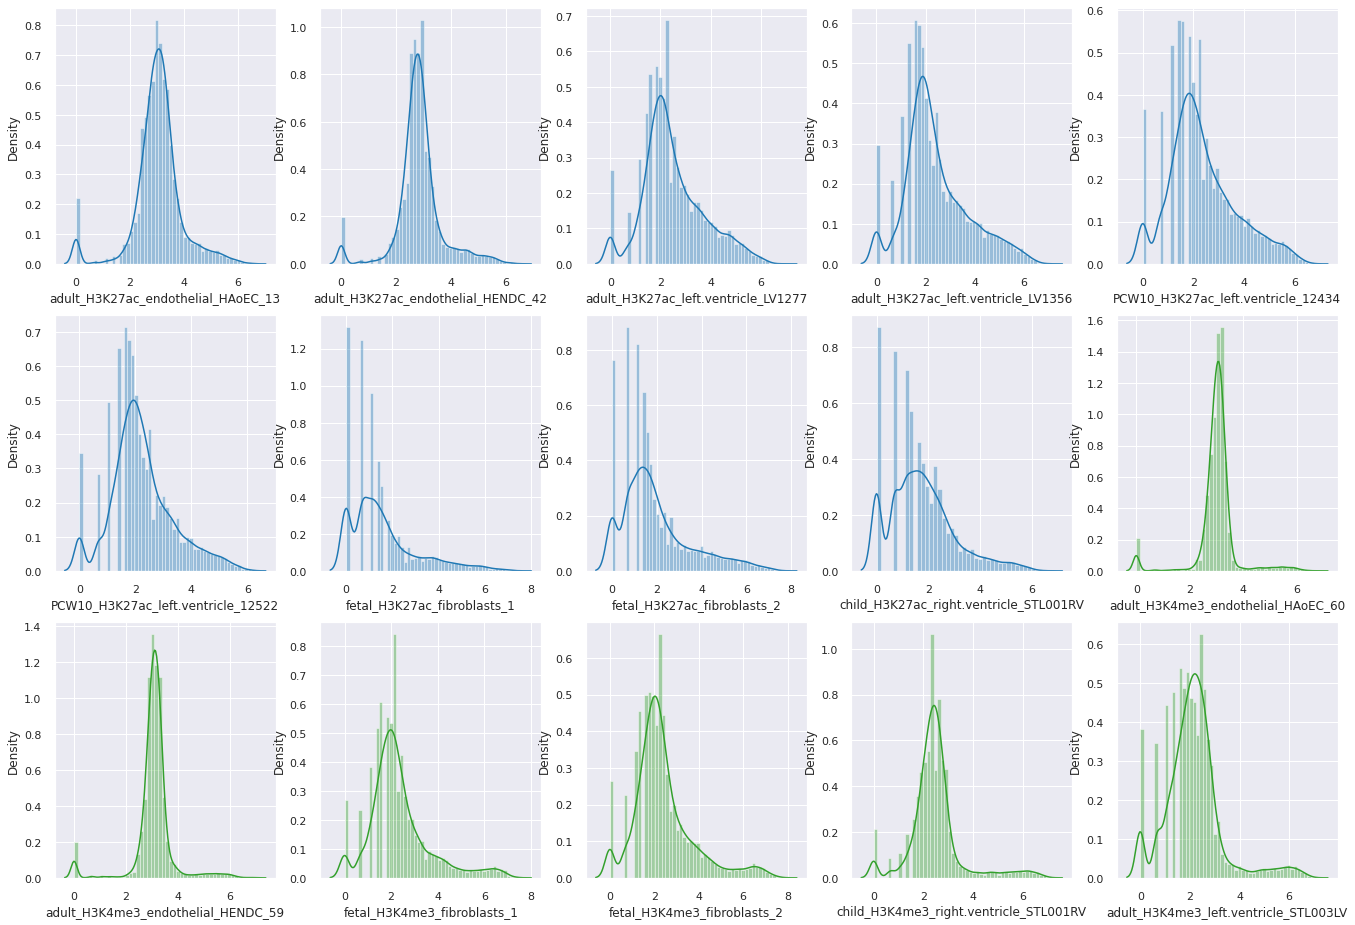

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
warnings.filterwarnings('ignore')

plt.style.use("seaborn")
sns.set(rc={"figure.figsize": (23, 16)})
# how to make this grid variable in size, depending on the 
# amount of samples I have. (now only 15 samples, but I want to run for >100)
fig, axes = plt.subplots(3, 5)

plt_x_ax = 0
plt_y_ax = 0

for mark in marks: 
    samples = list(dict_of_dfs[mark])
    for sample in samples:
        sns.distplot(dict_of_dfs[mark].get(sample),
                 hist=True,
                 rug=False,
                 label=sample,
                 axlabel=(sample),
                 norm_hist=False,
                 color=colors[mark],
                 ax=axes[plt_y_ax,plt_x_ax],
        )
        if plt_x_ax < 4:
            plt_x_ax = plt_x_ax + 1
        elif plt_x_ax == 4:
            plt_x_ax = 0
            plt_y_ax = plt_y_ax + 1

    fig.savefig(f"{exp_path}/Distribution_graphs_notNorm.pdf")


#### Quantile normalization on samples per mark

In [21]:
dict_norm_dfs = {}
for mark in marks:
    df = dict_of_dfs[mark]
    norm_df = qnorm.quantile_normalize(df, axis=1, ncpus=20)
    dict_norm_dfs[mark] = norm_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

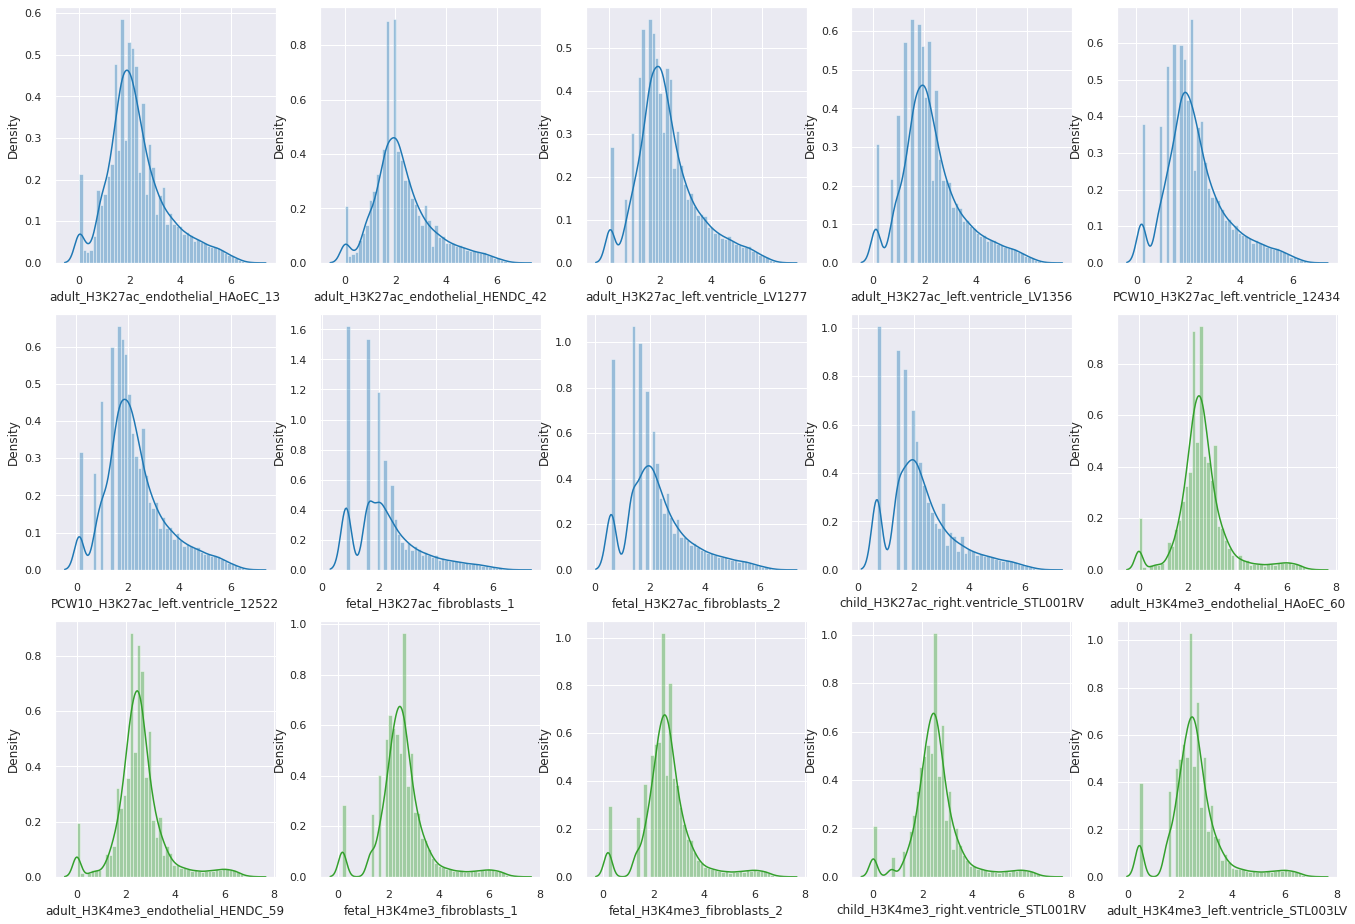

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn")
sns.set(rc={"figure.figsize": (23, 16)})
fig, axes = plt.subplots(3, 5)

plt_x_ax = 0
plt_y_ax = 0

for mark in marks:
    samples = list(dict_norm_dfs[mark])
    for sample in samples:
        sns.distplot(
            dict_norm_dfs[mark].get(sample),
            hist=True,
            rug=False,
            label=sample,
            axlabel=(sample),
            norm_hist=False,
            color=colors[mark],
            ax=axes[plt_y_ax, plt_x_ax],
        )
        if plt_x_ax < 4:
            plt_x_ax = plt_x_ax + 1
        elif plt_x_ax == 4:
            plt_x_ax = 0
            plt_y_ax = plt_y_ax + 1

    fig.savefig(f"{exp_path}/Distribution_graphs_qNorm.pdf")

### Exploratory visualization of the samples
Using PCA and heatmap representations.

In [24]:
# Generating a large df with both marks combined (which were normalized seperately)
merged_marks_df = pd.merge(
    left=dict_norm_dfs["H3K27ac"],
    right=dict_norm_dfs["H3K4me3"],
    on="region",
    how="inner",
    validate="one_to_one",
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Running PCA on the merged dataset

In [25]:
# Transpose df for PCA; making columns features/attributes and rows samples
merged_marks_tdf = merged_marks_df.T
pca = PCA(n_components=2)
pcs = pca.fit_transform(merged_marks_tdf)
pc_df = pd.DataFrame(data=pcs, columns=["PC1", "PC2"])
pc_df = pd.concat([pd.DataFrame(merged_marks_df.columns), pc_df], axis=1)
pc_meta = samples_meta[["descriptive_name", "target", "source_tissue"]]
pc_df = pd.merge(
    left=pc_df,
    right=pc_meta,
    left_on=0,
    right_on="descriptive_name",
    how="left",
)
pc_df = pc_df.drop(columns=0)
pc_df[:5]

,PC1,PC2,descriptive_name,target,source_tissue
0,10.534785,-22.953634,adult_H3K27ac_endothelial_HAoEC_13,H3K27ac,vascular_system
1,-10.026593,-6.782488,adult_H3K27ac_endothelial_HENDC_42,H3K27ac,vascular_system
2,-31.553337,-37.170146,adult_H3K27ac_left.ventricle_LV1277,H3K27ac,left_ventricle
3,-31.521573,-35.435435,adult_H3K27ac_left.ventricle_LV1356,H3K27ac,left_ventricle
4,-36.082601,-31.268715,PCW10_H3K27ac_left.ventricle_12434,H3K27ac,heart


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
print(
    "Explained variation per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

Explained variation per principal component: [0.27410891 0.24155804]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1656x1152 with 0 Axes>

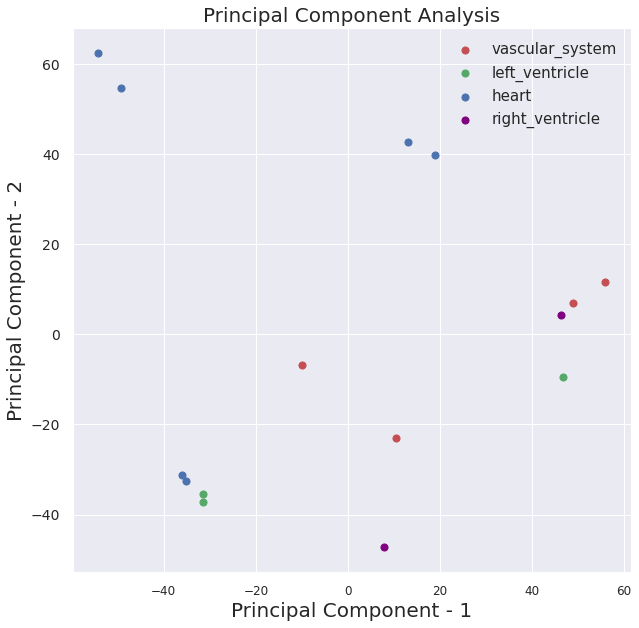

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Plot PCA with source_tissue labelling
plt.figure()
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel("Principal Component - 1", fontsize=20)
plt.ylabel("Principal Component - 2", fontsize=20)
plt.title("Principal Component Analysis", fontsize=20)

source_tissues = samples_meta["source_tissue"].unique()
# still need to make the colorscheme of a variable length,
# depending on the amount of tissues.
# colors = cm.get_cmap("viridis", len(source_tissues)).colors
colors = ["r", "g", "b", "purple"]
for target, color in zip(source_tissues, colors):
    indicesToKeep = pc_df["source_tissue"] == target
    plt.scatter(
        pc_df.loc[indicesToKeep, "PC1"],
        pc_df.loc[indicesToKeep, "PC2"],
        c=color,
        s=50,
    )

plt.legend(source_tissues, prop={"size": 15})
plt.savefig(f"{exp_path}/PCA_PC1-2_tissuesource.pdf")

<Figure size 1656x1152 with 0 Axes>

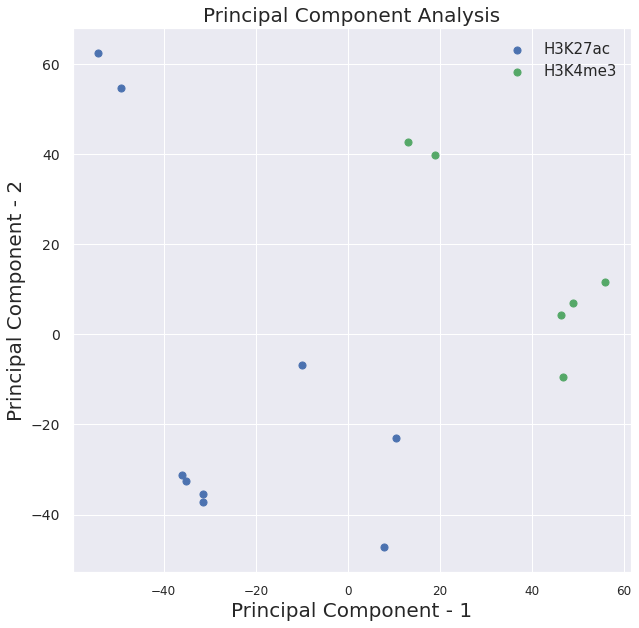

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# Plot PCA with mark labelling
plt.figure()
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel("Principal Component - 1", fontsize=20)
plt.ylabel("Principal Component - 2", fontsize=20)
plt.title("Principal Component Analysis", fontsize=20)

source_tissues = samples_meta["source_tissue"].unique()
colors = ["b", "g"]
for target, color in zip(marks, colors):
    indicesToKeep = pc_df["target"] == target
    plt.scatter(
        pc_df.loc[indicesToKeep, "PC1"],
        pc_df.loc[indicesToKeep, "PC2"],
        c=color,
        s=50,
    )

plt.legend(marks, prop={"size": 15})
plt.savefig(f"{exp_path}/PCA_PC1-2_marks.pdf")

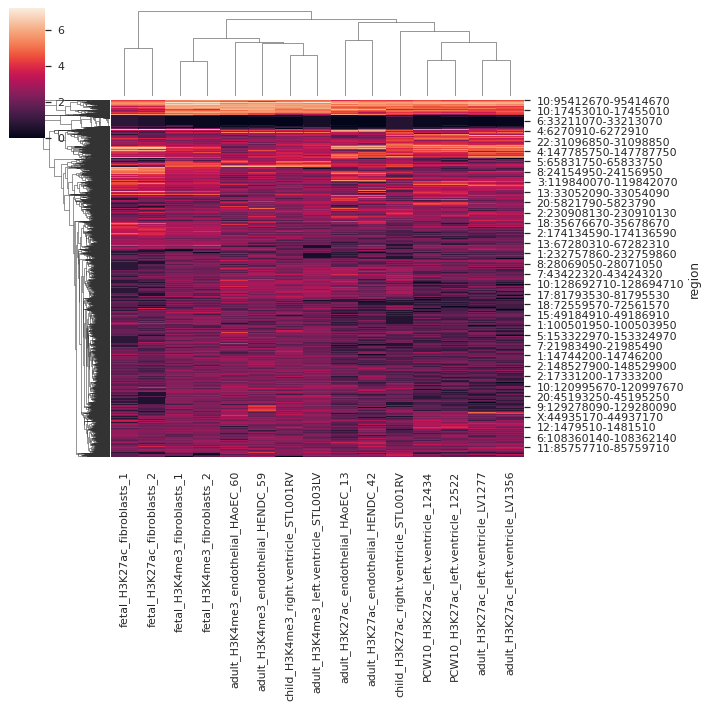

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
sns.clustermap(merged_marks_df)

In [30]:
!/vol/mbconda/snabel/anaconda3/condabin/conda list > {exp_path}/conda_env.txt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_above()'))

In [ ]:
## Use this example to make a PCA with size of sample as visual variable: 
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_demo2.html#sphx-glr-gallery-lines-bars-and-markers-scatter-demo2-py